# Packages

In [1]:
import torch
import segmentation_models_pytorch as smp
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from PIL import Image
import albumentations as albu
import argparse
import time
import cv2
from torch import nn
from tqdm import tqdm
import dlib

In [3]:
def denormalize(image, preprocessing_fn):
    """From image in [0,1] to [0,255] according to preprocessing function"""
    image = image * torch.tensor(preprocessing_fn.keywords['std']).view(-1,1,1) + torch.tensor(preprocessing_fn.keywords['mean']).view(-1,1,1)
    return image

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    input : 
        - preprocessing_fn : preprocessing function
    output :
        - transform : albumentations object
    """
    return albu.Lambda(image=preprocessing_fn)

def resize(input_size, deform="rectangular"):
    """Transformation for validation set
    input : 
        - input_size : integer for resizing maximum side
    output :
        - transform : albumentations object
    """
    if deform=="square":
        transform = albu.Resize(input_size, input_size)
    elif deform=="scale":
        transform = albu.LongestMaxSize(input_size)
    elif deform=="rectangular":
        transform = albu.Resize(input_size[0], input_size[1])
    else:
        print("deform argument unknown")
        
    return transform

In [4]:
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Parameters

In [5]:
# argument parser
input_dir      = "C:\\Users\\gueganj\\Desktop\\My_Database\\celebamask\\images_labelized\\"
prediction_dir = "C:\\Users\\gueganj\\Desktop\\My_Database\\celebamask\\prediction_cropped\\"
mask_dir       = "C:\\Users\\gueganj\\Desktop\\My_Database\\celebamask\\mask_image\\"
model_path     = 'C:\\Users\\gueganj\\Desktop\\model_size_image\\544_960.ckpt'
video_name     = "C:\\Users\\gueganj\\Desktop\\my_face\\video_prediction.avi"
# size to downsample image as in training
input_size = [960,544]
input_size[0] = input_size[0] - input_size[0] % 32
input_size[1] = input_size[1] - input_size[1] % 32
# save a video
save_video = False
save_images = False
# crop image with landmark or not
crop = False

# Load Model

In [6]:
model = smp.Unet(encoder_name="resnet34", encoder_weights='imagenet', activation='sigmoid')
checkpoint = torch.load(model_path,map_location=device)
if "module" in list(checkpoint['model'].keys())[0]:
    model = nn.DataParallel(model)
model.load_state_dict(checkpoint['model'])
model.eval()
model.to(device)
print()

# Prediction

In [7]:
# get image to predict
list_image = glob.glob(os.path.join(input_dir,'*.jpg'))
if not list_image:
    print("ERROR : no image found in input")

In [8]:
if save_video:
    frame = cv2.imread(list_image[0])
    height, width, layers = frame.shape
    fourcc = cv2.VideoWriter_fourcc(*'DIVX')
    video  = cv2.VideoWriter(video_name, fourcc, 30, (width,height))

In [9]:
# Normalize image
preprocessing_fn = smp.encoders.get_preprocessing_fn("resnet18", 'imagenet')

In [10]:
# dlib
detector  = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("file_landmarks.dat")

Loop on image to predict. Comment/Uncomment the last 2 lines to save images or not : *image_mean* is greyscale + prediction in red and *prediction* in binary mask (png)

In [11]:
for i in tqdm(list_image): #range(len(list_image))):
    # read
    image_full = np.array(Image.open(os.path.join(input_dir,i))) #'frame_'+str(i)+'.jpg')))
    size_full  = image_full.shape[:2]
    
    # cropped eyes zone
    if crop: 
        faces = detector(image_full)
        if not faces:
            print("no faces detected !")
        else:
            face = faces[0]
            landmarks = predictor(image_full, face)
            y1 = landmarks.part(21).y
            y2 = landmarks.part(33).y
            x1 = landmarks.part(0).x
            x2 = landmarks.part(16).x
            offset = int((x2-x1) * 0.15)
            x1 = x1 - offset
            x2 = x2 + offset
            y1 = y1 - int((y2-y1) * 0.25)
            y2 = y2 - int((y2-y1) * 0.15)
            image = image_full[y1:y2,x1:x2]
            size = image.shape[:2]
    # no cropp
    else:
        image = image_full
        size = size_full
            
    # resize
    sample = Image.fromarray(image).resize(input_size,Image.LANCZOS) #resize(input_size)(image=img_cropped)
    sample = np.array(sample)
    
    # apply normalization
    sample = get_preprocessing(preprocessing_fn)(image=sample)
    
    # transform to tensor format
    image = torch.Tensor(sample['image'].transpose(2, 0, 1).astype('float32')).unsqueeze(0)
    
    # prediction
    with torch.no_grad():
        proba = model.forward(image)
        prediction = (proba > 0.5).squeeze().numpy().astype('uint8')
    
    # resize to original size
    prediction = cv2.resize(prediction,(size[1],size[0]))
    
    # re-position it on full image if cropped
    if crop:
        prediction_cropped = prediction
        prediction = np.zeros(size_full)
        prediction[y1:y2,x1:x2] = prediction_cropped
        
    # format for segmentation display (currently only 1 class)
    image_mean = np.mean(image_full,axis=2).astype('uint8')
    image_mean = np.repeat(image_mean[:, :, np.newaxis], 3, axis=2)
    image_mean[prediction.astype(bool)] = [255,0,0]
    
    # save and display
    if save_images:
        image_name = i
        plt.imsave(os.path.join(prediction_dir,os.path.basename(image_name)),image_mean)
        plt.imsave(os.path.join(mask_dir,os.path.basename(image_name).replace('.jpg','.png')), prediction.squeeze())
    if save_video:
        video.write(image_mean)
        
if save_video:
    video.release()

100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [01:02<00:00,  2.30s/it]


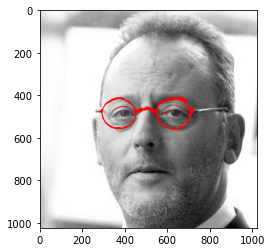

In [12]:
plt.imshow(image_mean)